## 나랑 닮은 연예인은 누구?

### 실습목표
- 임베딩에 대해 이해하고 얼굴의 임베딩 벡터를 추출합니다.
- 얼굴의 임베딩 벡터로 닮은 꼴인 얼굴을 찾습니다.
- 나와 가까운 연예인을 찾아냅니다.

## 얼굴임베딩 만들기(1) 얼굴인식

### 임베딩은 무엇일까?
 - 어떤 벡터 공간(Vector Space)에다가 우리가 표현하고자 하는 정보를 사상(mapping)하는 방법을 사용할 수밖에 없습니다.
 - 우리가 무언가를(단어이든, 이미지 오브젝트이든) 벡터로 표현한다면, 그것은 원점에서 출발한 벡터 공간상의 한 점이 될 것입니다. 
 - 그런데, 우리가 하고 싶은 것들은 모두 두 점 사이의 관계를 따져보고 싶은 것으로 귀결됩니다. 
 - 오늘 우리가 다루어 보고자 하는 [두 얼굴이 얼마나 닮았나] 하는 문제도 컴퓨터한테는 두 얼굴 벡터 사이의 거리가 얼마나 되나 하는 문제로 치환됩니다. 
 - 중요한 것은 두 점 사이의 거리가 실제로 두 오브젝트 사이의 유사도를 정확하게 반영해야 한다는 점입니다.
 - 닮은 얼굴을 찾기 위해서는 찾고자 하는 얼굴이 있는 사진과 비교하고 싶은 얼굴이 있는 사진을 비교해야 합니다.
 - 먼저 얼굴이 있는 가로, 세로가 100 pixel인 이미지가 있다고 생각해봅시다. 이미지가 동일하다면 이미지의 픽셀 수준에서 두 이미지 사이의 거리는 0이라고 볼 수 있겠죠?
 - 하지만 이런 방식은 이미지가 동일한지는 볼 수 있지만 얼굴이 동일한지 보기 어려울 뿐더러 사진이 가로x세로 100x100 pixel의 컬러 사진이라면 RGB 3개의 채널이 존재하므로 100x100x3 = 30000 차원의 벡터를 얼굴 개수만큼 비교해야 하는 일이 생깁니다. 
 - 너무 차원수가 높은 공간에서의 비교는 사실상 무의미해집니다. 이 문제를 해결하기 위해서 얼굴을 표현하는 이미지 벡터를 더 작은 차원으로 줄일 수 있지 않을까요?
 - 이렇게 고차원 정보를 저차원으로 변환하면서 필요한 정보를 보존하는 것이 임베딩입니다. 얼굴 이미지가 저차원으로 변환되고, 이 변환된 벡터에 누군지 알아볼 수 있는 정보가 남는다고 가정하면 임베딩 벡터만으로도 얼굴을 비교할 수 있게 됩니다.
 - 우리가 오늘 만나게 될 이미지 임베딩 모델은 위 그림처럼 이미지를 128차원의 얼굴임베딩 벡터로 변환해 줄 것입니다. 과연 임베딩 벡터간의 거리가 얼굴들 사이의 유사도를 얼마나 정밀하게 반영해 줄지 궁금해집니다.
 - 임베딩 벡터에 보존되어야 하는 필요한 정보라는 게 과연 뭘까요? 우리는 어떤 것의 절대적 의미를 벡터공간 상에 직접 부여할 수 있도록 하는 어떤 정보도 가지고 있지 않습니다. 우리가 가지고 있는 모든 정보는 상대적입니다. 
 - A는 B에 비해 C에 더 가깝다라는 상대적인 비교수치 말고는 우리가 컴퓨터에게 넘겨줄 수 있는 정보가 없습니다. 이런 정보가 최대한 보존되도록 어떤 오브젝트를 벡터 공간 상에 매핑시켜야 그 벡터는 매핑된 오브젝트의 임베딩 역할을 할 수 있게 됩니다. 우리는 다음 스텝에서 이런 원리를 통해 얼굴임베딩 벡터 사이의 거리가 두 얼굴이 얼마나 닮았는지를 잘 반영하도록 딥러닝을 통해 학습하는 사례를 접하게 될 것입니다.
 
### 얼굴 영역만을 정확하게 인식해서 추출하기
- 우리가 오늘 사용해 볼 얼굴 인식 라이브러리는 dlib을 사용해서 만들어진 Face Recognition 라이브러리입니다. 
- dlib은 아주 널리 쓰이는 Object Detection 패키지입니다. 어쩌면 이미 몇번 사용해 보셨을지도 모르겠군요. 
- dlib에는 이미 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾는 face detector 기능을 제공하고 있습니다. 
- 아래 그림에서도 보다시피 dlib의 얼굴 인식 정확도는 99.38%에 달한다고 합니다.

### 얼굴인식 테스트해보기
- 샘플 이미지의 obama.jpg를 불러온 후 얼굴을 face_recognition.face_locations를 사용해 찾아줍니다. 그렇게 박스를 찾게 되면 임베딩 추출을 할 이미지를 만들기 위해서 잘라줍니다. 얼굴 부분이 잘 탐지되었는지 확인해 볼까요?

[(98, 758, 284, 572)]


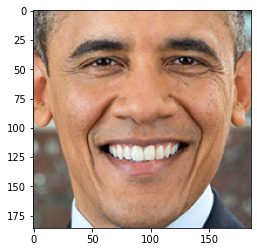

In [122]:
import face_recognition
import os

image_path = os.getenv('HOME')+'/aiffel/E12_similar_face/face_embedding/images/obama.jpg'
image = face_recognition.load_image_file(image_path)
face_locations = face_recognition.face_locations(image)

print(face_locations)  # 이미지에서 얼굴 영역의 좌표를 출력합니다.

%matplotlib inline
import matplotlib.pyplot as plt

a, b, c, d = face_locations[0]
cropped_face = image[a:c,d:b,:]

plt.imshow(cropped_face)   # 이미지에서 얼굴영역만 잘라낸 cropped_face를 그려 봅니다.

우리는 5명의 대통령 사진을 방금 images 디렉토리에 저장해 두었습니다. 이미지 파일 경로를 파라미터로 넘기면 얼굴 영역만 잘라서 뿌려주는 함수를 하나 만들어 두면 앞으로도 유용하게 사용할 수 있을 것 같습니다. 한번 직접 만들어 보시겠어요?

In [123]:
import face_recognition
import os

def get_gropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

잘 만들어 졌는지, 이번에는 trump.jpg의 얼굴 영역을 가져와 봅시다.

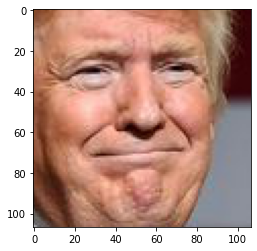

In [124]:
image_path = os.getenv('HOME')+'/aiffel/E12_similar_face/face_embedding/images/trump.jpg'

cropped_face = get_gropped_face(image_path)
plt.imshow(cropped_face)

## 얼굴임베딩 만들기(2) FaceNet

### 얼굴의 유사도를 측정해 주는 방법: FaceNet의 Triplet Loss

- 얼굴의 특징을 추출하고 적은 차원의 벡터로 만들기 위해서 저희는 딥러닝을 사용합니다. 그렇다면 딥러닝 모델이 얼굴의 특징을 잘 비교할 수 있는 모델이 되도록 학습하려면 어떻게 해야 할까요?
- 2015년 구글에서 발표한 FaceNet을 통해 배워보도록 합시다. FaceNet은 우리가 봐왔던 딥러닝 모델과 크게 다른 것은 없지만 네트워크 뒤에 L2 Normalization을 거쳐 임베딩을 만들어 내고 여기에 Triplet Loss를 사용하고 있습니다.
- L2 Normalization부터 하나씩 살펴봅시다. L2 Normalization은 모델 결과물의 L2 Distance를 구한 후에 이것으로 결과물을 나눠주어 Normalization을 해주는 과정입니다.이렇게 L2 Normalization 레이어를 거쳐나온 임베딩 벡터는 벡터의 크기가 1로 맞춰질 것이므로, 128차원의 공간상에 반지름이 1인 구가 있다고 할때, 구의 표면상의 한 점을 가리키는 벡터처럼 분포될 것입니다. 이렇게 제약조건을 주면 이후 두 점 사이의 거리를 계산할 때 두 벡터의 절대적 크기에 무관하게 두 벡터 사이의 각도에만 영향을 받게 될 것입니다.
- 그럼 Triplet Loss는 무엇일까요? FaceNet 논문에서 소개하는 아래 그림을 살펴봅시다.
- The Triplet Loss minimizes the distance between an anchor and a positive, both or which have the same identity, and maximizes the distance between the anchor and a negative of a different identity.
- Triplet Loss는 이름에서 볼 수 있듯이 세 개의 데이터 쌍을 이용해 계산하는 손실함수로 네트워크를 학습시킬 수 있습니다.
- 시작할 때 임베딩 벡터 안에 보존되어야 할 정보는 A는 B에 비해 C에 더 가깝다라는 상대적인 비교수치밖에 없다는 언급을 한 적이 있습니다. 
- Triplet Loss 개념은 정확하게 이런 아이디어를 반영하고 있습니다. 사람 얼굴 데이터셋에서 A와 C는 같은 사람의 얼굴 사진에서 나온 임베딩 벡터, B는 다른 사람의 얼굴 사진에서 만들어진 임베딩 벡터가 되도록 데이터셋을 구성합니다. 그렇다면 정확히 A는 B에 비해 C에 더 가깝다라는 논리가 성립해야만 할 것입니다.
- Triplet Loss는 같은 사람은 이 임베딩 벡터 A-C간의 거리를 가깝게 그리고 다른 사람의 임베딩 벡터 B-C간의 거리를 멀게 학습을 시키는 효과를 가져옵니다. 그림에서 보듯 같은 사람의 얼굴에서 나온 임베딩이 멀리 배치된다면 학습을 통해서 가까워지도록 임베딩 벡터를 만들어 내는 것이죠!

이전 스텝에서 얼굴 영역을 인식하는 데 사용했던 Face Recognition에는 바로 위에 소개한 FaceNet 얼굴 임베딩 모델이 탑재되어 있습니다. 이 모델을 이용하여 우리가 다운받아 둔 5장의 이미지에서 얼굴 임베딩을 추출해 봅시다.

In [125]:
import os

dir_path = os.getenv('HOME')+'/aiffel/E12_similar_face/face_embedding/images'
file_list = os.listdir(dir_path)

print ("file_list: {}".format(file_list))

file_list: ['trump.jpg', 'biden.jpg', 'clinton.jpeg', '.ipynb_checkpoints', 'bush.jpeg', 'obama.jpg']


그러면 obama.jpg에 포함된 얼굴 영역의 임베딩 벡터를 구해 봅시다. 이전 스텝에서 이미지 파일의 얼굴 영역을 가져오는 getgroppedface() 함수를 구현한 바 있습니다. 이를 활용해 봅시다. Face Recognition 패키지에서 제공하는 얼굴 임베딩 벡터 구하기 함수는 facerecognition.faceencodings()입니다. 다음 코드와 같이 사용하면 됩니다.



In [126]:
import numpy as np

image_file = os.path.join(dir_path, 'obama.jpg')
face = get_gropped_face(image_file)   # 얼굴 영역을 구하는 함수(이전 스텝에서 구현)

# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

embedding = get_face_embedding(face)  
embedding

len(embedding)

1

여러분들의 images 디렉토리 안에 있는 모든 이미지 파일의 임베딩을 구해서 dict 구조에 담아 리턴하는 함수를 하나 만들어 봅시다. 딕셔너리의 각 엘리먼트는 사람이름:임베딩벡터로 하겠습니다. 다음과 같이 사용하고 싶은 것입니다 .

In [127]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}

    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_gropped_face(img_path)
        embedding = get_face_embedding(face)
        if len(embedding) > 0:  # 얼굴영역 face가 제대로 detect되지 않으면  len(embedding)==0인 경우가 발생하므로 
                    # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
     
    return embedding_dict

In [129]:
# get_face_embedding_dict() 함수가 잘 만들어졌는지 확인해 봅시다.

embedding_dict = get_face_embedding_dict(dir_path)
embedding_dict['trump']

array([-0.15962467,  0.20268655,  0.0323635 ,  0.02439232, -0.06226439,
        0.05140705,  0.07351795, -0.16823348,  0.06962204, -0.05557961,
        0.17270109, -0.05094168, -0.35293093, -0.0316438 ,  0.03792984,
        0.17343847, -0.13260126, -0.15357377, -0.23523533, -0.08442692,
       -0.00134139,  0.03210667, -0.08926154, -0.02670781, -0.09581181,
       -0.25792354, -0.01056999, -0.11071672,  0.03133569, -0.07444921,
        0.05670552, -0.02273796, -0.19461137, -0.04576054,  0.00947582,
        0.01806056, -0.1502624 , -0.07787319,  0.17577608,  0.01933258,
       -0.19744575, -0.03930519,  0.07374467,  0.20196027,  0.1476755 ,
       -0.0141539 ,  0.0172476 , -0.11976205,  0.09462971, -0.24318144,
       -0.02755127,  0.12169892,  0.14837705,  0.17079785,  0.06952555,
       -0.15360466,  0.02005427,  0.08199155, -0.19544823,  0.10653654,
        0.11468476, -0.21902837, -0.07677591, -0.06791042,  0.10587606,
        0.05921567, -0.06115703, -0.11171092,  0.23917492, -0.15

## 얼굴임베딩 사이의 거리측정

이제 임베딩과 Triplet Loss를 이해하고, 임베딩 벡터를 실제로 구해 보았으므로, 임베딩 공간 속에서 임베딩 벡터들의 거리가 어떤 의미인지 알아보도록 하겠습니다.

Triplet Loss는 설명드린대로 같은 사람의 얼굴 쌍을 임베딩 공간 상에서 가깝도록 그리고 다른 사람의 얼굴 쌍을 멀도록 학습시킵니다. 즉, 이를 이용해 학습된 모델에서는 임베딩 공간에서 서로 다른 사람의 얼굴의 임베딩 거리가 멀게 표현되어 있습니다.

그렇다면 이 모델에서 거리가 먼 두 얼굴 이미지의 임베딩은 서로 다른 사람일 확률이 높다고 볼 수 있고 가까우면 같은 사람일 확률이 높다고 볼 수 있습니다. 그럼 실제로 한번 비교해볼까요?

In [130]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

get_distance('obama', 'trump')

0.8885117374787042

## 얼굴임베딩 공간의 시각화

- 임베딩 벡터를 직접 넘파이 배열로 보니 벡터들이 어떻게 가깝고 먼지 감이 잘 오지 않습니다. 그리고 128차원의 벡터를 우리가 눈으로 볼 수 있도록 시각화를 할수도 없습니다.
- 고차원 데이터를 저차원으로 바꾼 임베딩처럼 이런 다차원 벡터를 시각화하기 위해서 차원축소를 하는 방법들이 있습니다. 예를 들어 PCA, T-SNE 등이 있습니다. 그럼 임베딩을 시각화하면 어떤 식으로 배치가 되는지 확인해보겠습니다. 
- TensorFlow의 Projector는 고차원 벡터를 차원 축소 기법을 사용해서 눈으로 확인할 수 있게 해줍니다. 아래 링크에서 어떤식으로 우리 눈으로 볼 수 있는지, 그리고 같은 사람끼리는 어떤 식으로 배치되는지 직접 확인해봅시다.
- PCA 와 T-SNE 를 이용해 우리가 쉽게 볼 수 있는 형태로 차원을 축소할 수 있었습니다. 조금 더 자세히 알아볼까요?
    - 먼저 PCA 는 주성분 분석이라는 방법으로 Principal Component Analysys 의 준말입니다. 이 방법은 모든 차원의 축에 따른 값의 변화도인 분산(Variance)를 확인한 뒤 그 중 변화가 가장 큰 주요한 축을 남기는 방법입니다.
    - T-SNE 는 고차원 상에서 먼 거리를 저차원 상에서도 멀리 배치되도록 차원을 축소하는 방식입니다. 먼저 random하게 목표하는 차원에 데이터들을 배치한 후 각 데이터들을 고차원 상에서의 배치와 비교를 하면서 위치를 변경해 주는 알고리즘으로 이해하시면 됩니다.
- 위의 시각화에서 보듯이 PCA에서는 모든 차원이 잘 반영되지 않는 반면 T-SNE는 Iteration을 거칠 수록 가까운 벡터들이 잘 군집한 형태로 차원 축소가 되는 것을 볼 수 있습니다. 자세한 내용은 아래 참고자료를 확인해 보세요.

## 가장 닮은꼴 얼굴 찾아보기

- 이전 스텝에서 우리는 다음 기능을 함수로 구현해 보았습니다.
    - def get_gropped_face(image_file) : 이미지 파일에서 얼굴 영역을 가져오는 함수
    - def get_face_embedding(face) : 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수
    - def get_face_embedding_dict(dir_path) : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수
    - def get_distance(name1, name2) : 두 이미지(사람이름) 사이의 임베딩 벡터 거리를 구하는 함수
- 이제 필요한 정보를 다 가지고 있으므로, 이제는 특정 이미지와 가장 닮은 이미지를 구해보는 기능을 만들 수 있을 것입니다.
- 우리가 만들고 싶은 함수는 다음과 같이 쓸 수 있기를 바랍니다. name 인자에 특정 사람 이름을 주면 그 사람과 가장 닮은 다른 이미지와 거리 정보를 가장 가까운 순으로 정렬해서 표시해 주어야 합니다.

In [131]:
# name1과 name2의 거리를 비교하는 함수를 생성하되, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 합니다.
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

sort_key_func = get_sort_key_func('trump')   
# 이렇게 생성된 함수 sort_key_func는 sort_key_func('obama') 라고 호출할 때 trump와 obama 사이의 임베딩 벡터 거리를 계산합니다.

우리는 이미 모든 이미지 파일에 대한 얼굴 임베딩 딕셔너리를 가지고 있습니다.
이제 우리는 이 딕셔너리를 오름차순 정렬하되, 정렬 기준을 바로 trump와의 임베딩 벡터 거리 함수로 할 것입니다. 이때 lambda 함수가 정렬 key로 활용됩니다.

In [132]:
sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))

[('trump',
  array([-0.15962467,  0.20268655,  0.0323635 ,  0.02439232, -0.06226439,
          0.05140705,  0.07351795, -0.16823348,  0.06962204, -0.05557961,
          0.17270109, -0.05094168, -0.35293093, -0.0316438 ,  0.03792984,
          0.17343847, -0.13260126, -0.15357377, -0.23523533, -0.08442692,
         -0.00134139,  0.03210667, -0.08926154, -0.02670781, -0.09581181,
         -0.25792354, -0.01056999, -0.11071672,  0.03133569, -0.07444921,
          0.05670552, -0.02273796, -0.19461137, -0.04576054,  0.00947582,
          0.01806056, -0.1502624 , -0.07787319,  0.17577608,  0.01933258,
         -0.19744575, -0.03930519,  0.07374467,  0.20196027,  0.1476755 ,
         -0.0141539 ,  0.0172476 , -0.11976205,  0.09462971, -0.24318144,
         -0.02755127,  0.12169892,  0.14837705,  0.17079785,  0.06952555,
         -0.15360466,  0.02005427,  0.08199155, -0.19544823,  0.10653654,
          0.11468476, -0.21902837, -0.07677591, -0.06791042,  0.10587606,
          0.05921567, -0.06

이제 거의 다 왔습니다. 이제 우리는 'trump'에 대해서가 아니라, 입력받은 임의의 이름에 대해 다른 이미지의 임베딩 거리를 정렬해서 적절히 출력해 주기만 합니다. 우리가 목표로 하던 함수를 직접 구현해 봅시다.

In [133]:
def get_nearest_face(name, top=4):
    ret_dict = {}
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))

    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0],sort_key_func(sorted_faces[i][0])))

    return sorted_faces[1][0]

In [134]:
# obama와 가장 닮은 사람은 누굴까요?
get_nearest_face('obama')

순위 1 : 이름(biden), 거리(0.846720652777963)
순위 2 : 이름(bush), 거리(0.8628473227070342)
순위 3 : 이름(trump), 거리(0.8885117374787042)
순위 4 : 이름(clinton), 거리(0.9000994624487408)


'biden'

## 프로젝트 : 나랑 닮은 연예인을 찾아보자

### Step1. 사진 모으기

비교하려면 사진을 모아야겠죠? 우선 나만 볼테니 내 사진과 비교해 보고 싶은 연예인 사진을 모아봅시다. 평소에 닮았다고 생각했던 연예인 사진들을 모두 모아보는 것도 좋을 것 같네요.
사진을 하나의 디렉토리 안에 모아 봅시다. 모을 때 사진의 파일명은 가급적 장동건.jpg, 김태희.png와 같이 파일명이 사람 이름이 들어 있도록 하는 것이 좋습니다. (설마 이분들과 닮았다고 생각하시는 것은?? 😅)

1. 내 사진 찍기 
    - 내 사진을 2장 이상 포함합시다.
    - 내 사진들끼리의 얼굴 임베딩 벡터 거리를 구해 봅시다. 닮았음을 확인할 수 있는 좋은 베이스라인이 될 수 있습니다.
    - 혹시 내 사진들끼리의 거리가 멀게 나온다면 왜 그럴지 생각해 봅시다.
    

2. 비교할 연예인 사진 모으기
    - 많이 모을 수록 나와 더 닮은 연예인을 찾을 가능성이 높아질 것입니다.
    - 주위의 동료들과 모은 사진을 주고받는 것도 하나의 방법입니다.

In [135]:
import numpy as np
import face_recognition
import os 
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm

## Step2. 얼굴 영역 자르기
- 임베딩 추출을 위해서는 얼굴 영역을 잘라줘야 합니다. 
- 위 Step1.에서 찾은 이미지들을 이전에 만들었던 get_gropped_face(image_file)을 통해서 잘라줍시다! 
- 자른 이미지는 PIL의 Image.fromarray를 통해서 PIL Image로 변환한 뒤에 저장을 해두면 다양한 재미있는 시각화를 시도해 보는데 도움이 될 것입니다.

In [136]:
def get_cropped_face(image_path):
    image = face_recognition.load_image_file(image_path)
    face_location = face_recognition.face_locations(image)
    if len(face_location) >0:
        a, b , c, d = face_location[0]
        cropped_face = image[a:c, d:b, :]
        return cropped_face
    else:
        return []

## Step3. 얼굴 영역의 임베딩 추출하기

이제 얼굴 영역으로 잘린 이미지들이 여럿 생겼을텐데요. 그 이미지를 face_recognition 를 사용해서 이미지를 불러오고 임베딩을 추출해 봅시다. 다른 사람의 임베딩은 구분할 수 있게 따로 저장해 주세요. 이전에 만들었던 다음 함수들을 활용하면 손쉽게 수행 가능합니다.

- def get_face_embedding(face) : 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수
- def get_face_embedding_dict(dir_path) : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수


In [137]:
# 얼굴 임베딩
def get_face_embedding(face_image):
    return face_recognition.face_encodings(face_image)

In [138]:
# 임베딩 딕셔너리
def get_face_embedding_dict(dir_path, embedding_dict):
    file_list =os.listdir(dir_path)  
    file_name = file_list[0].split('_')[0]
    
    for file in tqdm(file_list):
        img_path = os.path.join(dir_path, file)
        face = get_cropped_face(img_path)
        if len(face) ==0:
            continue
        embedding = get_face_embedding(face)
        if len(embedding) > 0:
            embedding_dict.setdefault(file_name, []).append((embedding[0], file))
    return embedding_dict

## Step4. 모은 연예인들과 비교하기

- 모은 연예인 사진들과 자신의 얼굴 사진에서 추출한 임베딩 벡터들 간의 거리를 비교해 보고 가장 작은 연예인이 누구인지 찾아봅시다!

- 이전 스텝에서 만들었던 get_nearest_face(name, top=5) 함수들을 응용하면 손쉽게 수행 가능합니다.

In [139]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

In [140]:
def get_distance2(embed_dict, name1_array, name2):
    distance = []
    for i in embed_dict[name2]:
        dis = np.linalg.norm(name1_array - i[0], ord=2)
        distance.append(dis)
    return distance

In [141]:
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

In [142]:
def similar_picture2(embed_dict, name1, name1_index):
    # 비교할 사진 불러오기
    my_pic_path = os.path.join('./data',name1, embed_dict[name1][name1_index][1])
    my_pic = get_cropped_face(my_pic_path)
    
    # 가지고 있는 전체 사진에서 가장 거리가 가까운 사진 찾기
    # 사진을 기준으로 반복문
    names = list(embed_dict.keys())
    dis_dict = {}
    for name in names:
        # 비교 대상의 사진은 넘어가기
        if name == name1:
            continue
        # 거리 계산 후 각 대상별 거리가 가장 가까운 값과 인덱스 저장    
        distance = get_distance2(embed_dict, embed_dict[name1][name1_index][0], name)
        min_value = min(distance)
        index = distance.index(min_value)
        dis_dict[name] = (min_value, index)
    # 가장 닮은 꼴 사진 불러오기    
    min_distance = tuple(dis_dict.values())
    min_distance2 = [a for a, _ in min_distance]
    index = min_distance2.index(min(min_distance2))
    
    picked = tuple(dis_dict.keys())[index]
    index2 = dis_dict[picked][1]

    sim_pic_path = os.path.join('./data', picked, embed_dict[picked][index2][1])
    get_face = get_cropped_face(sim_pic_path)
    ###################시각화#######################
    fig = plt.figure(figsize=(20,15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    ax1.set_title('Face')
    ax2.set_title('Similar Face')
    
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    ax1.imshow(my_pic)
    ax2.imshow(get_face)

    plt.show()

In [143]:
def similar_picture(embed_dict,name1, name1_index, name2):
    '''
    name1_array : 비교할 사진 index
    name2 : 비교 대상
    '''
    # embed_dict[key][value][index] / index 0 : embedding array, index 1 : file name
    my_pic_path = os.path.join('./data',name1, embed_dict[name1][name1_index][1])
    my_pic = get_cropped_face(my_pic_path)
    
    distance = get_distance2(embed_dict, embed_dict[name1][name1_index][0], name2)
    min_value = min(distance)
    index = distance.index(min_value)
    
    sim_pic_path = os.path.join('./data',name2, embed_dict[name2][index][1]) 
    get_face = get_cropped_face(sim_pic_path)
    
    fig = plt.figure(figsize=(20,15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    
    ax1.set_title('Face')
    ax2.set_title('Similar Face')
    
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    ax1.imshow(my_pic)
    ax2.imshow(get_face)

    plt.show()

In [144]:
embed_dict =dict()

In [146]:
import os

os.listdir()

['trump.jpg', 'biden.jpg', 'clinton.jpeg', 'bush.jpeg', 'obama.jpg']

In [147]:
os.getcwd()

'/home/aiffel0042/aiffel/E12_similar_face/face_embedding/images'

In [148]:
os.chdir('../../')

In [149]:
os.getcwd()

'/home/aiffel0042/aiffel/E12_similar_face'

In [150]:
embed_dict = get_face_embedding_dict('./data/채시라', embed_dict)
embed_dict = get_face_embedding_dict('./data/김윤경', embed_dict)
embed_dict = get_face_embedding_dict('./data/견미리', embed_dict)

100%|██████████| 97/97 [00:16<00:00,  5.84it/s]


In [151]:
embed_dict

{'채시라': [(array([-0.11754919,  0.06666373,  0.00266549, -0.11018931, -0.15339403,
          -0.04925111, -0.11434459, -0.13143641,  0.1619224 , -0.18933736,
           0.13573283, -0.12169105, -0.18032706, -0.00987059, -0.0900459 ,
           0.20198128, -0.16702101, -0.1500459 , -0.04212495, -0.00690151,
           0.07911438,  0.02057455,  0.000969  ,  0.0888596 , -0.11336598,
          -0.32285875, -0.07556038, -0.0487877 , -0.01032851, -0.02907358,
          -0.05549569,  0.04165474, -0.18064764, -0.04580606,  0.03576225,
           0.10568863,  0.03229971, -0.11321582,  0.16620025, -0.05744719,
          -0.28648955,  0.04975897,  0.08165396,  0.21330346,  0.1797397 ,
          -0.01893982,  0.0028122 , -0.20137572,  0.16634305, -0.14931783,
           0.01544075,  0.09556717,  0.04864921,  0.01011907,  0.05424232,
          -0.13287963,  0.0432159 ,  0.15539467, -0.12242557, -0.03692832,
           0.10646942, -0.04045126, -0.01446984, -0.1779813 ,  0.24258024,
           0.09190

## Step5. 다양한 재미있는 시각화 시도해 보기

- 비단 닮은 꼴 연예인을 찾기만 할 것이 아니라, 그들의 얼굴 사진을 활용하여 재미있는 시각화를 시도해 보시기 바랍니다.
- tkinter나 flask를 활용해서 닮은꼴을 찾을 이미지를 업로드한 후 그 이미지와 닮은 얼굴을 찾는 형태로 구현해 보는 것도 재미있을 것입니다.
- 여러분들의 재치가 넘치는 작품들을 기대합니다. 😎

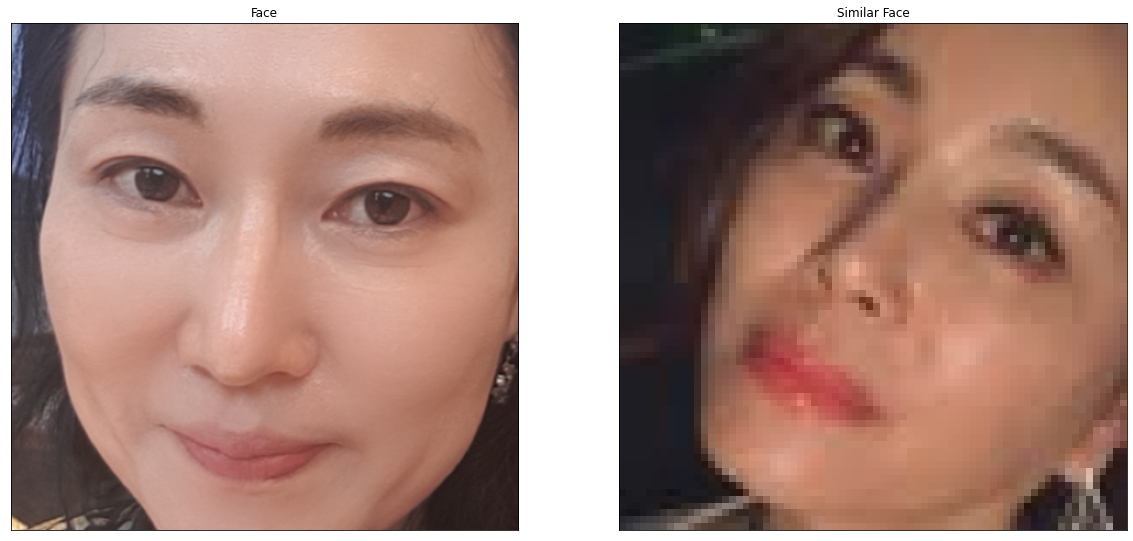

In [152]:
similar_picture(embed_dict, '김윤경', 0, '견미리')

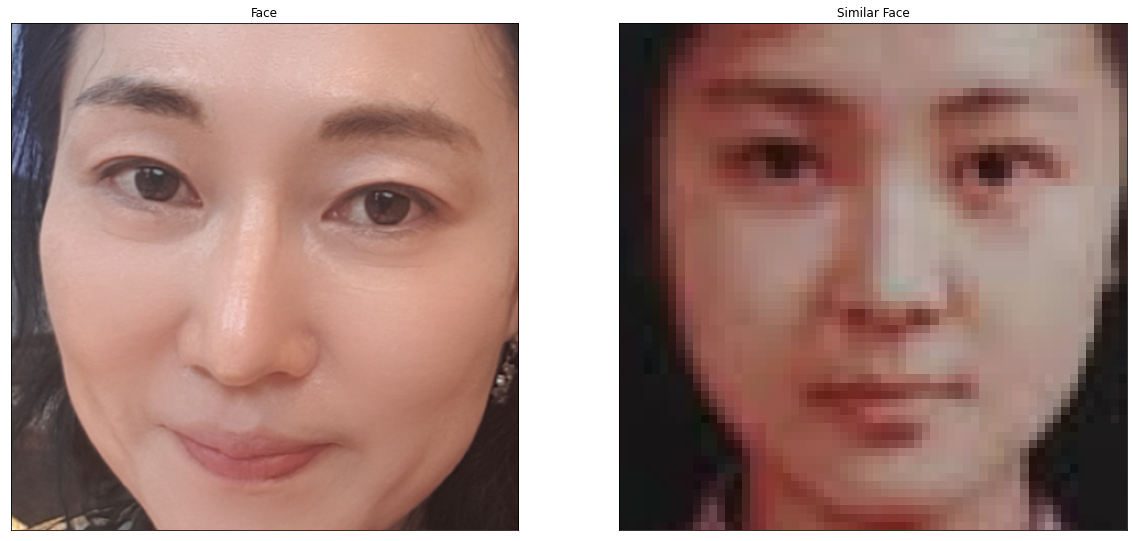

In [153]:
similar_picture(embed_dict, '김윤경', 0, '채시라')

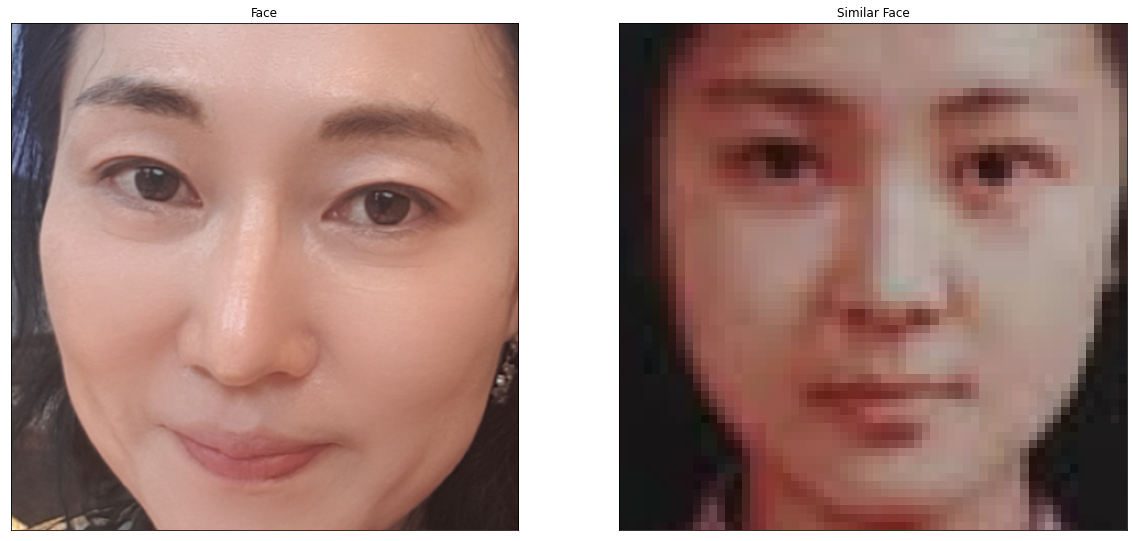

In [154]:
similar_picture2(embed_dict, '김윤경', 0)

## 프로젝트 소감

연예인 얼굴과 내 얼굴을 비교하는 과정에서 구글에서 크롤링 해온 이미지들의 사이즈가 너무 작아서 해상도가 깨지는 것이 아쉬웠다. 
그래도 이쁜 연예인과 닮았다고 하니까, 기분은 좋네요~